<a href="https://colab.research.google.com/github/cloudhood/learning-basics/blob/main/notebooks/dalex_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade dalex lime pandas statsmodels tensorflow  &> /dev/null

In [2]:
%matplotlib inline

In [3]:
import dalex as dx
import pandas as pd
import tensorflow as tf

## Versions

In [4]:
!python --version

Python 3.7.13


In [5]:
for m in (dx, pd, tf):
    print(f"{m.__name__}: {m.__version__}")

dalex: 1.4.1
pandas: 1.3.5
tensorflow: 2.9.1


## Load data

In [6]:
url = "https://raw.githubusercontent.com/pbiecek/xai-happiness/main/happiness.csv"
df = pd.read_csv(url, index_col=0)

In [7]:
X, y = df.drop('score', axis=1), df.score
n, p = X.shape

## Build model

In [8]:
tf.random.set_seed(123)

In [9]:
normalizer = tf.keras.layers.experimental.preprocessing.Normalization(
    input_shape=[p,]
)

In [10]:
normalizer.adapt(X.to_numpy())

In [11]:
model = tf.keras.Sequential([
    normalizer,
    tf.keras.Input(shape=(p,)),
    tf.keras.layers.Dense(p*2, activation='relu'),
    tf.keras.layers.Dense(p*3, activation='relu'),
    tf.keras.layers.Dense(p*2, activation='relu'),
    tf.keras.layers.Dense(p, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])

In [12]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.mae
)

In [13]:
model.fit(X, y, batch_size=int(n/10), epochs=2000, verbose=False)

## Explain model

In [14]:
explainer = dx.Explainer(
    model, X, y, label="happiness"
)

Preparation of a new explainer is initiated

  -> data              : 156 rows 6 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 156 values
  -> model_class       : keras.engine.sequential.Sequential (default)
  -> label             : happiness
  -> predict function  : <function yhat_tf_regression at 0x7fa55bbaec20> will be used (default)
1/1 [==============================] - 0s 116ms/step
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
5/5 [==============================] - 0s 4ms/step
  -> predicted values  : min = 2.9, mean = 5.43, max = 7.83
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
5/5 [==============================] - 0s 3ms/step
  -> residuals         : min = -1.62, mean = -0.0224, max = 0.79
  -> model_info        : package keras

A new explainer has been created!


In [15]:
## Assess model fit
explainer.model_performance()

,mse,rmse,r2,mae,mad
happiness,0.037338,0.193231,0.969671,0.086628,0.037236


In [16]:
## Variable importance
explainer.model_parts().plot()

5/5 [==============================] - 0s 3ms/step


In [17]:
# Continuous relationships between predictors and variables (Ceteris Paribus)
explainer.model_profile().plot(
    variables=['social_support', 'healthy_life_expectancy',
               'gdp_per_capita', 'freedom_to_make_life_choices']
)

Calculating ceteris paribus:   0%|          | 0/6 [00:00<?, ?it/s]

493/493 [==============================] - 1s 2ms/step


Calculating ceteris paribus:  17%|█▋        | 1/6 [00:01<00:05,  1.07s/it]

493/493 [==============================] - 1s 2ms/step


Calculating ceteris paribus:  33%|███▎      | 2/6 [00:02<00:04,  1.10s/it]

493/493 [==============================] - 1s 2ms/step


Calculating ceteris paribus:  50%|█████     | 3/6 [00:03<00:03,  1.05s/it]

493/493 [==============================] - 1s 2ms/step


Calculating ceteris paribus:  67%|██████▋   | 4/6 [00:04<00:02,  1.03s/it]

493/493 [==============================] - 1s 2ms/step


Calculating ceteris paribus:  83%|████████▎ | 5/6 [00:05<00:01,  1.14s/it]

493/493 [==============================] - 1s 2ms/step


Calculating ceteris paribus: 100%|██████████| 6/6 [00:06<00:00,  1.10s/it]

5/5 [==============================] - 0s 3ms/step


In [18]:
# Residuals
model_diag = explainer.model_diagnostics()

model_diag.plot(
    variable='social_support', 
    yvariable="abs_residuals", 
    marker_size=5, 
    line_width=3
)

In [19]:
model_diag.result

,gdp_per_capita,social_support,healthy_life_expectancy,freedom_to_make_life_choices,generosity,perceptions_of_corruption,y,y_hat,residuals,abs_residuals,label,ids
Afghanistan,0.350,0.517,0.361,0.000,0.158,0.025,3.203,3.273819,-0.070819,0.070819,happiness,1
Albania,0.947,0.848,0.874,0.383,0.178,0.027,4.719,4.733962,-0.014962,0.014962,happiness,2
Algeria,1.002,1.160,0.785,0.086,0.073,0.114,5.211,5.270841,-0.059841,0.059841,happiness,3
Argentina,1.092,1.432,0.881,0.471,0.066,0.050,6.086,6.104103,-0.018103,0.018103,happiness,4
Armenia,0.850,1.055,0.815,0.283,0.095,0.064,4.559,4.610397,-0.051397,0.051397,happiness,5
...,...,...,...,...,...,...,...,...,...,...,...,...
Venezuela,0.960,1.427,0.805,0.154,0.064,0.047,4.707,4.769798,-0.062798,0.062798,happiness,152
Vietnam,0.741,1.346,0.851,0.543,0.147,0.073,5.175,5.226868,-0.051868,0.051868,happiness,153
Yemen,0.287,1.163,0.463,0.143,0.108,0.077,3.380,3.712451,-0.332451,0.332451,happiness,154
Zambia,0.578,1.058,0.426,0.431,0.247,0.087,4.107,4.102907,0.004093,0.004093,happiness,155


In [20]:
# Specific country
explainer.predict_parts(X.loc['Poland'], type='shap').plot()

5/5 [==============================] - 0s 4ms/step


In [21]:
# Several countries
pp_list = []
for country in ['Afghanistan', 'Belgium', 'China', 'Denmark', 'Ethiopia']:
    pp = explainer.predict_parts(X.loc[country], type='break_down')
    pp.result.label = country
    pp_list += [pp]

pp_list[0].plot(pp_list[1::], min_max=[2.5, 8.5])

5/5 [==============================] - 0s 7ms/step


157/157 [==============================] - 0s 2ms/step


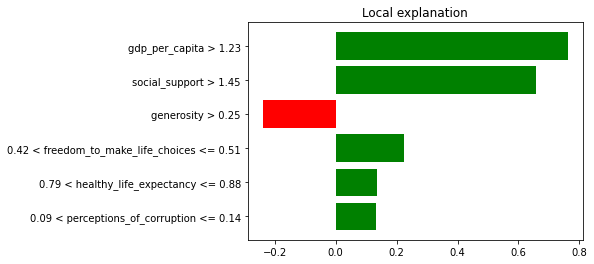

In [22]:
# Surrogate approximation
lime_explanation = explainer.predict_surrogate(
    X.loc['United States'], 
    mode='regression'
)

lime_explanation.plot()

In [23]:
lime_explanation.result

,variable,effect
0,gdp_per_capita > 1.23,0.761159
1,social_support > 1.45,0.657584
2,generosity > 0.25,-0.238247
3,0.42 < freedom_to_make_life_choices <= 0.51,0.223153
4,0.79 < healthy_life_expectancy <= 0.88,0.134399
5,0.09 < perceptions_of_corruption <= 0.14,0.131602


In [24]:
# Interpretable surrogate model
surrogate_model = explainer.model_surrogate(max_vars=4, max_depth=3)
surrogate_model.performance

5/5 [==============================] - 0s 3ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names



,mse,rmse,r2,mae,mad
DecisionTreeRegressor,0.180555,0.424918,0.843219,0.349502,0.332628


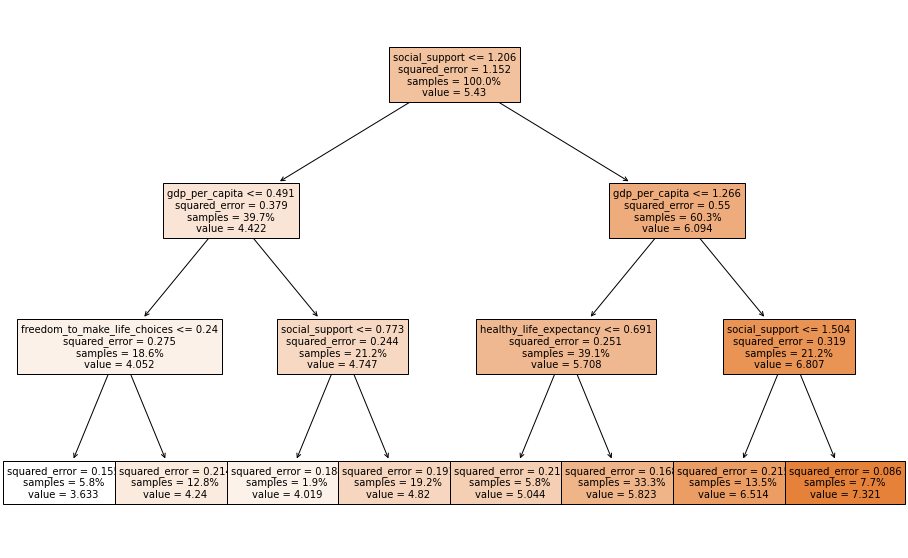

In [25]:
surrogate_model.plot()